In [1]:
using PyPlot
using LowRankApprox
using DataFrames
using Roots
using Distributions

In [13]:
Y = Array{Float64,2}(readtable("EQTLSumStats_strong.txt", header = false));
include("ash.jl");
include("mixSQP.jl");
include("update_functions.jl");

Stacktrace:
 [1] depwarn(::String, ::Symbol) at ./deprecated.jl:70
 [2] #readtable#229(::Bool, ::Char, ::Array{Char,1}, ::Char, ::Array{String,1}, ::Array{String,1}, ::Array{String,1}, ::Bool, ::Int64, ::Array{Symbol,1}, ::Array{Any,1}, ::Bool, ::Char, ::Bool, ::Int64, ::Array{Int64,1}, ::Bool, ::Symbol, ::Bool, ::Bool, ::DataFrames.#readtable, ::String) at /Users/yosikim/.julia/v0.6/DataFrames/src/deprecated.jl:1045
 [3] (::DataFrames.#kw##readtable)(::Array{Any,1}, ::DataFrames.#readtable, ::String) at ./<missing>:0
 [4] include_string(::String, ::String) at ./loading.jl:522
 [5] execute_request(::ZMQ.Socket, ::IJulia.Msg) at /Users/yosikim/.julia/v0.6/IJulia/src/execute_request.jl:158
 [6] (::Compat.#inner#18{Array{Any,1},IJulia.#execute_request,Tuple{ZMQ.Socket,IJulia.Msg}})() at /Users/yosikim/.julia/v0.6/Compat/src/Compat.jl:378
 [7] eventloop(::ZMQ.Socket) at /Users/yosikim/.julia/v0.6/IJulia/src/eventloop.jl:8
 [8] (::IJulia.##14#17)() at ./task.jl:335
while loading In[13], in 

In [27]:
function spca(X; iter = 100, init = "by_svd",
              precision_type = "rowwise_constant",
              return_type = "posterior_mean",
              nv = 20, nullprior = 20,
              convtol = 1e-8,
              verbose = true)
    # initialize
    n,p = size(X);
    if init == "by_svd"
        temp = svds(X, nsv = 1)[1];
        u = temp[:U] * sqrt(n); u2 = u.^2;
        v = temp[:V] * temp[:S] / sqrt(n); v2 = v.^2;
    elseif init == "by_random"
        u = randn(n); u = u/norm(u); v = X'*u; u2 = u.^2; v2 = v.^2;
    else
        error("Error")
    end
    X2 = X.^2; i = 0; temp = 0;
    R2 = update_R2(X, X2, u, u2, v, v2);
    tau = update_tau(R2, precision_type);
    
    # loop start
    for i = 1:iter
        
        v_old = v/norm(v);
        
        # update u
        u, u2 = update_u(X, tau, v, v2, precision_type);
        
        # update v
        temp = update_v(X, tau, u, u2, precision_type, nv, nullprior);
        v = temp[:pm]; v2 = temp[:pm2];
        
        # update tau
        R2 = update_R2(X, X2, u, u2, v, v2)
        tau = update_tau(R2, precision_type)
        
        a = norm(v); b = norm(v/norm(v) - v_old);
        if b < convtol
            break;
        end
        
        if verbose == true && rem(i,50) == 0
            print(i); println("-th iteration done with norm(v) = $a and error $b");
        end

    end
    
    out = Dict([
                (:u, u), (:u2, u2), (:v, v), (:v2, v2), (:tau, tau), (:temp, temp), (:iter, i)
                ])
    
    if return_type == "posterior_median"
        v_med = compute_posterior_median(temp);
        out[:v_med] = v_med;
    end
    
    return out
end

function compute_posterior_median(temp)
    
    # redefine
    x = temp[:x]; comp_post_prob = temp[:cpp];
    comp_post_mean = temp[:cpm]; comp_post_sd2 = temp[:cps2];
    
    ind = find(comp_post_prob[:,1] .< 0.5);
    post_median = zeros(length(x));
    for i in ind
        a = comp_post_prob[i,2:end];
        b = comp_post_mean[i,2:end];
        c = comp_post_sd2[i,2:end];
        d = comp_post_prob[i,1];
        
        # post_cdf
        function post_cdf(x)
            return a' * erfc.((x - abs.(b))./sqrt.(2*c)) + d - 0.5
        end
        post_median[i] = fzero(post_cdf,-1,1e2) * sign(x[i]);
    end
    return post_median
end

compute_posterior_median (generic function with 1 method)

In [28]:
k_max = 10; n,p = size(Y); R = Y .- mean(Y,1);
loading = zeros(n,k_max); factor = zeros(p,k_max);
for iter = 1:k_max
    if iter > 1
        R = R - loading[:,iter-1] * factor[:,iter-1]';
    end
    out = spca(R, iter = 1000, nv = 10, convtol = 1e-5, nullprior = 20,
           init = "by_svd",
           return_type = "posterior_median",
           precision_type = "columnwise_constant",
           verbose = true);
    loading[:,iter] = out[:u]; factor[:,iter] = out[:v_med]; i = out[:iter];
    print_with_color(:red,"$iter-th factor/loading done with iteration $i\n")
end

1-th factor/loading done with iteration 5
2-th factor/loading done with iteration 12
50-th iteration done with norm(v) = 2.433199384631819 and error 0.0013486201519918937
100-th iteration done with norm(v) = 2.4428505917213355 and error 0.0011572009634775871
150-th iteration done with norm(v) = 2.456752200260479 and error 0.005180457428154918
200-th iteration done with norm(v) = 2.4708636973383524 and error 0.0004893415650115098
3-th factor/loading done with iteration 234
50-th iteration done with norm(v) = 2.0279340576023737 and error 5.822225344265712e-5
4-th factor/loading done with iteration 58
50-th iteration done with norm(v) = 1.5322804033519688 and error 0.004342741480290488
5-th factor/loading done with iteration 98
50-th iteration done with norm(v) = 1.8032412411521201 and error 0.0007850363700425469
100-th iteration done with norm(v) = 1.807420010559961 and error 0.00011669603346578503
150-th iteration done with norm(v) = 1.8081755202046974 and error 2.2487397196307034e-5
6-

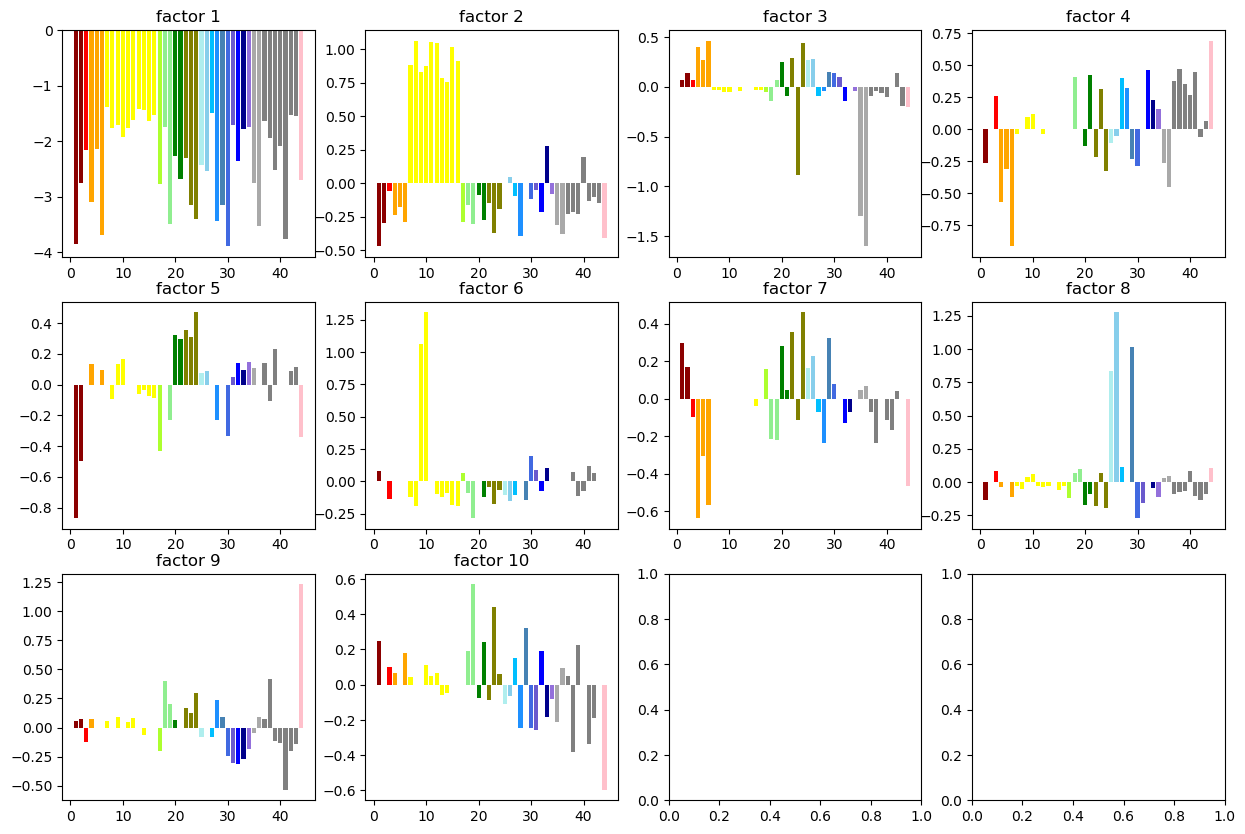

In [34]:
col =  [:darkred; :darkred; :red; :orange; :orange; :orange; repeat([:yellow], inner = 10);
        :greenyellow; :lightgreen; :lightgreen; :green; :green; :olive; :olive; :olive;
        :paleturquoise; :skyblue; :deepskyblue; :dodgerblue; :steelblue; :royalblue; :slateblue; :blue;
        :darkblue; :mediumpurple; :darkgray; :darkgray; repeat([:gray], inner = 7); :pink]
fig, ax = subplots(3,4, figsize = (15,10))
for i = 1:10
    subplot(3,4,i);
    bar(1:44, factor[:,i], color = col);
    title("factor $i")
end
savefig("F1.pdf")

In [36]:
k_max = 10; Z = Y'; n,p = size(Z); R = Z .- mean(Z,1);
loading = zeros(n,k_max); factor = zeros(p,k_max);
for iter = 1:k_max
    if iter > 1
        R = R - loading[:,iter-1] * factor[:,iter-1]';
    end
    out = spca(R, iter = 1000, nv = 10, convtol = 1e-5, nullprior = 100,
           init = "by_svd",
           return_type = "posterior_median",
           precision_type = "columnwise_constant",
           verbose = true);
    loading[:,iter] = out[:u]; factor[:,iter] = out[:v_med]; i = out[:iter];
    print_with_color(:red,"$iter-th factor/loading done with iteration $i\n")
end

50-th iteration done with norm(v) = 105.77551814610489 and error 8.404321185869998e-5
100-th iteration done with norm(v) = 110.45771183656478 and error 7.028052291123918e-5
150-th iteration done with norm(v) = 114.66440933587224 and error 5.8925410849069916e-5
200-th iteration done with norm(v) = 118.34673740675194 and error 4.860416243331208e-5
250-th iteration done with norm(v) = 121.44905437998597 and error 3.897432951559692e-5
300-th iteration done with norm(v) = 123.95195523544139 and error 3.021984193715592e-5
350-th iteration done with norm(v) = 125.88762657643585 and error 2.266082874974684e-5
400-th iteration done with norm(v) = 127.3298697789062 and error 1.6496369263563004e-5
450-th iteration done with norm(v) = 128.37231368793138 and error 1.1722391321308952e-5
1-th factor/loading done with iteration 473
50-th iteration done with norm(v) = 44.276604962032664 and error 0.00010453890828594252
100-th iteration done with norm(v) = 46.37776699898472 and error 7.972270464704333e-

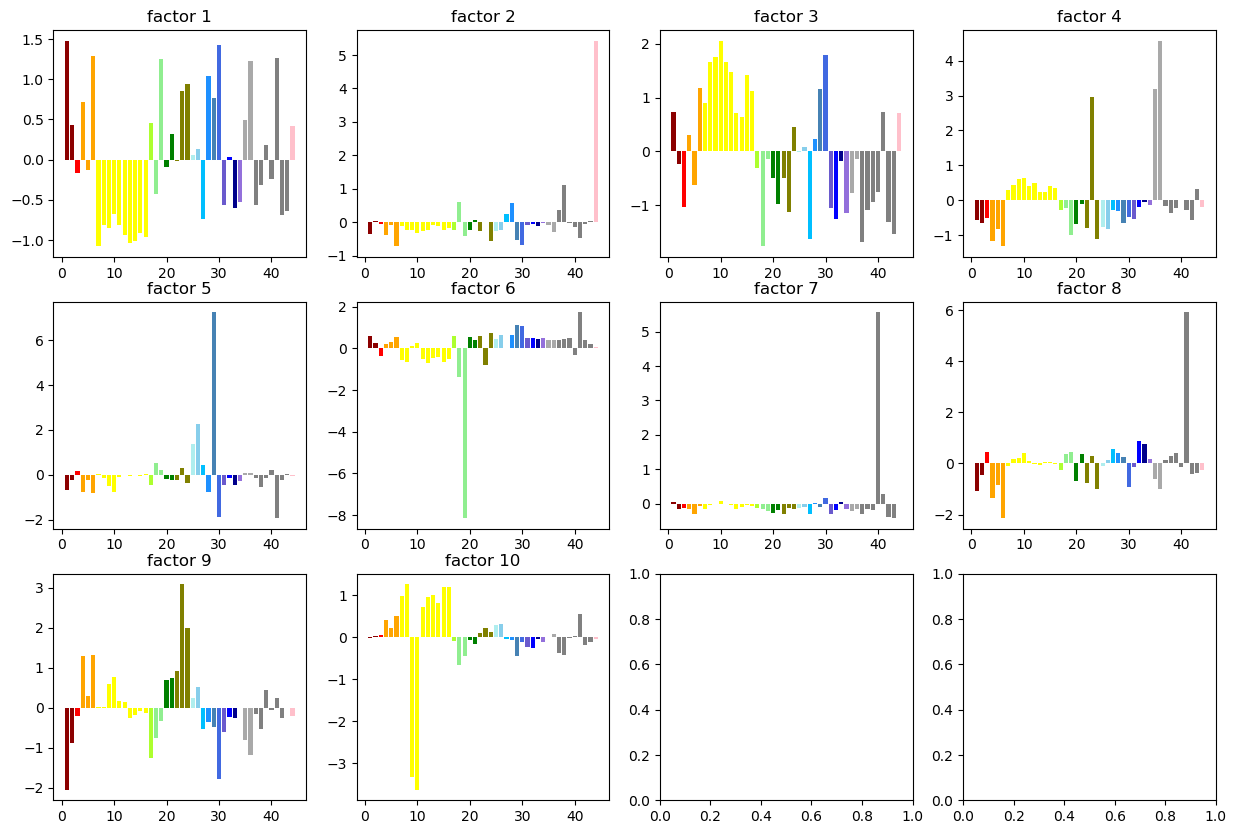

In [39]:
col =  [:darkred; :darkred; :red; :orange; :orange; :orange; repeat([:yellow], inner = 10);
        :greenyellow; :lightgreen; :lightgreen; :green; :green; :olive; :olive; :olive;
        :paleturquoise; :skyblue; :deepskyblue; :dodgerblue; :steelblue; :royalblue; :slateblue; :blue;
        :darkblue; :mediumpurple; :darkgray; :darkgray; repeat([:gray], inner = 7); :pink]
fig, ax = subplots(3,4, figsize = (15,10))
for i = 1:10
    subplot(3,4,i);
    bar(1:44, loading[:,i], color = col);
    title("factor $i")
end
savefig("F2.pdf")